**Basic Geometric Shape Classifier using Pytorch
Author: Sirmad Mahmood Hashmi Class Project for: Geometric Modeling

In [100]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas
import matplotlib.image as mpimg
import requests
import torch.utils.data as data
import numpy as np

import os
import torch.nn.functional as F
from torch.autograd import Variable

**Data Loader(training folder): Shape -> train ->: circle,square,star,triangle
**Data Loader(testing folder): Shape -> test ->: circle,square,star,triangle
**Image resized to 32x32 pixels

In [101]:
#root="C:/Users/Sirmad Hashmi/Documents/msc/3rdsem/shapes"
BATCH_SIZE = 4
TRAIN_DATA_PATH = "C:/Users/Sirmad Hashmi/Documents/msc/3rdsem/shapes/train"
TEST_DATA_PATH = "C:/Users/Sirmad Hashmi/Documents/msc/3rdsem/shapes/test"
TRANSFORM_IMG = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) 

classes = ('circle', 'square', 'star', 'triangle')

**Function for displying Images in data folder

triangle  star  star square


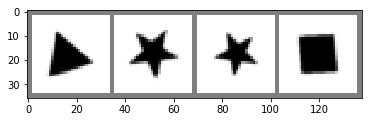

In [102]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    #plt.imshow((out * 255).astype(np.uint8))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Neural Network is definded

In [103]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

**Loss Function 'CrossEntropyLoss' optimizer 'stochastic gradient descent' learning rate '0.001' momentum '0.9'

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Traning the model training cycle of 2 epochs

In [105]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.409
[2,  2000] loss: 0.003
Finished Training


**Testing our Model

GroundTruth:  circle circle circle circle


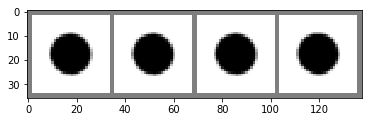

In [107]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [109]:
outputs = net(images)
outputs

tensor([[22.4070, 11.9632, -8.6974, -7.4012, -1.7475, -4.9283, -1.8890, -1.6875,
         -3.3982, -4.9100],
        [22.4306, 11.9681, -8.7105, -7.4097, -1.7496, -4.9316, -1.8888, -1.6900,
         -3.3984, -4.9130],
        [22.3033, 11.9607, -8.6637, -7.3371, -1.7383, -4.9236, -1.8890, -1.6961,
         -3.3772, -4.8995],
        [22.3066, 12.0299, -8.6113, -7.3727, -1.7582, -4.9268, -1.9125, -1.7063,
         -3.3946, -4.9231]], grad_fn=<ThAddmmBackward>)

**Predicting values 

In [110]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  circle circle circle circle


**Accuracy of Model

In [112]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 100 %


**Acurracy According to each label

In [116]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of circle : 100 %
Accuracy of square : 100 %
Accuracy of  star : 100 %
Accuracy of triangle : 100 %
